In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.ndimage import gaussian_filter1d

In [2]:
np.random.seed(5)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
x = [1,2,3,4,5]
y = slice(0,2)
x[y]

[1, 2]

In [4]:
'''
returns a inp_event_max ** inp_num, inp_num, inp_event_max shape matrix of all possible input events
This was made by chatgpt
'''

def generate_combinations(inp_num, inp_event_max):
    total_combinations = inp_event_max ** inp_num
    combinations = np.zeros((total_combinations, inp_event_max, inp_num), dtype=int)

    for i in range(total_combinations):
        temp = i
        for j in range(inp_num):
            index = temp % inp_event_max
            combinations[i, index,j] = 1
            temp = temp // inp_event_max

    return combinations

In [5]:
def calc_reps(T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, inp_delay_range, rec_delay_range,V_th):
        # Function to simulate a spiking neural network with recurrent connections and input events.

    # Some parameters are passed to the function:
    # T: Total duration of the simulation.
    # start_time: Starting time for input events.
    # end_time: Ending time for input events.
    # inp_num: Number of input neurons.
    # rec_num: Number of excitatory recurrent neurons.
    # inh_num: Number of inhibitory recurrent neurons.
    # inh_duration: Duration for which inhibitory neurons have an effect on excitatory neurons.
    # inp_delay_range: Range of input delays.
    # rec_delay_range: Range of recurrent delays.
    # V_th: Threshold voltage for spike generation.

    # Randomly generate input delays for each input neuron.
    # Randomly generate recurrent delays for all neurons.
    # Initialize arrays to store input and recurrent events.
    # Iterate through combinations of input events using a recursive loop.
    # Calculate the total number of recurrent spikes and the percentage of independent responses.

    # Return the simulated events, neuron labels, and statistics (total_spikes, pct_response).
    # (thanks chatgpt ^^^)
    
    inp_event_max = inp_delay_range[1]-inp_delay_range[0]

    inp_delays = np.random.randint(*inp_delay_range,(inp_num ,rec_num))
    rec_delays = np.random.randint(*rec_delay_range,(rec_num+inp_num+inh_num,rec_num+inp_num+inh_num))
    inp_delays.shape,rec_delays.shape
    all_input_events = np.zeros((inp_event_max**inp_num, T, inp_num))
    all_rec_events = np.zeros((inp_event_max**inp_num, T,rec_num))
    all_events = np.zeros((inp_event_max**inp_num,T,inp_num+rec_num+inh_num))
    

    '''
    this needs to be a recursive loop since we don't know how mnay inputs there will be!
    '''
    idc = 0
    curr_inp = 0
    all_input_events[:,start_time:start_time+inp_event_max,:] = generate_combinations(inp_num, inp_event_max)
    nrn_labels = np.array(inp_num*[0] + rec_num*[1] + inh_num*[2])
    
    rec_label=2
    
# all_input_events[-1,:,:]
    idc=0
    for inp_events in all_input_events:
        rec_events = np.zeros((T,rec_num+inh_num))
    #     inp = np.random.randint(0,10,(inp_num))
    #     inp_events = np.zeros((T,inp_num))
    #     for i in range(inp_num):
    #         inp_events[start_time+inp[i],i] =1
    #     inp_events.shape

        for t in range(1+start_time,end_time):
            for j in range(rec_num): # this for loop only iterates over excitatory recurrent neurons
                I = 0

                for i in range(inp_num):
                    I += inp_events[t-inp_delays[i,j],i]
                for i in range(rec_num+inh_num):
                    if i!=j:
                        I += rec_events[t-rec_delays[i,j],i]/2 # this offsets their label value

                if I>V_th:
                    rec_events[t,j] =2
                else:
                    rec_events[t,j] =0

            for j in range(rec_num,rec_num+inh_num): # this loop only iterates over inhbiitory recurrent neurons
                I = 0

                for i in range(rec_num):
                    if i!=j:
                        I += rec_events[t-rec_delays[i,j],i]


                if I>1:
                    rec_events[t,j] =-2
                else:
                    rec_events[t,j] =0

        events = np.zeros((T,inp_num+rec_num+inh_num))
        events[:,:inp_num] = inp_events
        events[:,inp_num:inp_num+rec_num+inh_num] = rec_events
        all_events[idc]=events
    #     all_rec_events[]
        idc+=1
        
        '''
        Do stats in the same method...?
        
        '''
        
        pct_response = 0 # pct of independent responses
    all_events_bin = np.zeros_like(all_events)
    all_events_bin[all_events != 0] = 1
    total_spikes = np.mean(np.sum(all_events_bin,axis=(1,2))-inp_num) # number of rec spikes for each trial    
    pct_response = ((inp_event_max ** inp_num - 
                    len(np.where(np.sum(all_events_bin,axis=(1,2))-inp_num == 0)[0])) / 
                    inp_event_max ** inp_num) # Pct of non-zero recurrent responses to input
    
    
    return all_events, nrn_labels, (total_spikes, pct_response)
    

# all_rec_events, evoked_spikes, temporal_depth,  unique_signatures = calc_reps(**params)

In [6]:

T = 100 # miliseconds of simulation time
start_time=10
end_time=90
inp_num = 2
rec_num = 4
inh_num = 2
nrns = np.array((inp_num*[0]+rec_num*[1]+inh_num*[2]))

inh_duration = 2
inp_delay_range=(1,5)
rec_delay_range=(1,5)
inp_event_max=4
V_th=1

default_params = {
    'T' : T, # miliseconds of simulation time
    'start_time':start_time,
    'end_time':end_time,
    'inp_num' : inp_num,
    'rec_num' : rec_num,
    'inh_num' : inh_num,
    'inh_duration' : inh_duration,
    'inp_delay_range':inp_delay_range,
    'rec_delay_range':rec_delay_range,
    'V_th':V_th
}

colors = np.array(['#1f77b4', '#1f77b4', '#1f77b4', '#d62728', '#d62728', '#d62728', '#d62728', '#d62728', '#d62728', '#17becf'])
colors = np.array(inp_num*['#1f77b4'] + rec_num*['#d62728'] + inh_num*['#17becf'])

In [7]:
trials = 1

all_events = np.zeros((trials, inp_event_max**inp_num,T,inp_num+rec_num+inh_num))

for trial in tqdm(range(trials)):
    all_events[trial],nrn_labels, stats = calc_reps(**default_params)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.67it/s]


In [8]:
stats

(4.875, 0.5)

In [9]:
all_events.shape, inp_num

((1, 16, 100, 8), 2)

# statistics!

In [35]:
scan_dict = {
    'inp_num':[2,3],
    'rec_num':[2,3,4,5,6,9,13,20],
    'inh_num':[1,2,3,4,8,12],
    'inh_duration':[1,2,3,4,5],
    'inp_delay_range':[(1,5),(1,6),(1,7),(1,8),(1,10),(1,15),(1,20)],
    'rec_delay_range':[(1,5),(1,6),(1,7),(1,10)],
    'V_th':[1,2,3,4,5]
}

In [36]:
T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, inp_delay_range, rec_delay_range,V_th = params.values()

In [41]:
# Import required libraries and functions (assuming they are already defined)
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar

# Simulation parameters
T = 100
start_time = 10
end_time = 90

# Initialize an empty list to store the results for each parameter combination
results_list = []

# Calculate the total number of parameter combinations
total_combinations = (len(scan_dict['inp_num']) *
                     len(scan_dict['rec_num']) *
                     len(scan_dict['inh_num']) *
                     len(scan_dict['inh_duration']) *
                     len(scan_dict['inp_delay_range']) *
                     len(scan_dict['rec_delay_range']) *
                     len(scan_dict['V_th']))

# Create a tqdm object for the parameter sweep
# param_combinations = tqdm(total=None, desc='Parameter Combinations', position=0, leave=True)

# Perform the parameter sweep
for idx, inp_num in enumerate(scan_dict['inp_num']):
    for rec_num in scan_dict['rec_num']:
        for inh_num in scan_dict['inh_num']:
            for inh_duration in scan_dict['inh_duration']:
                for inp_delay_range in scan_dict['inp_delay_range']:
                    for rec_delay_range in scan_dict['rec_delay_range']:
                        for V_th in scan_dict['V_th']:
                            # Create a new set of parameters for each combination
                            params = {
                                'T': T,
                                'start_time': start_time,
                                'end_time': end_time,
                                'inp_num': inp_num,
                                'rec_num': rec_num,
                                'inh_num': inh_num,
                                'inh_duration': inh_duration,
                                'inp_delay_range': inp_delay_range,
                                'rec_delay_range': rec_delay_range,
                                'V_th': V_th
                            }

                            trials = 1  # You can change the number of trials here if needed
                            T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, inp_delay_range, rec_delay_range,V_th = params.values()                            
                            inp_event_max = inp_delay_range[1] - inp_delay_range[0]
                            all_events = np.zeros((trials, inp_event_max**inp_num, T, inp_num + rec_num + inh_num))

                            for trial in range(trials):
                                all_events[trial], nrn_labels, stats = calc_reps(**params)

                            # Process the simulation results or save them for later analysis
                            # For example, you can calculate statistics and store them in a dictionary
                            # for each parameter combination

                            # Calculate statistics
                            total_spikes, pct_response = stats
                            avg_total_spikes = np.mean(total_spikes)
                            avg_pct_response = np.mean(pct_response)

                            # Create a dictionary to store the results for the current parameter combination
                            result_dict = {
                                'inp_num': inp_num,
                                'rec_num': rec_num,
                                'inh_num': inh_num,
                                'inh_duration': inh_duration,
                                'inp_delay_range': inp_delay_range,
                                'rec_delay_range': rec_delay_range,
                                'V_th': V_th,
                                'avg_total_spikes': avg_total_spikes,
                                'avg_pct_response': avg_pct_response
                            }

                            # Append the dictionary to the results list
                            results_list.append(result_dict)

                            # Update the progress bar for parameter combinations
#                             param_combinations.update(1)

                            # Append the dictionary to the results list
                            results_list.append(result_dict)

                            # Calculate the progress percentage and update the progress bar
                            progress = (idx * len(scan_dict['rec_num']) * len(scan_dict['inh_num']) *
                                        len(scan_dict['inh_duration']) * len(scan_dict['inp_delay_range']) *
                                        len(scan_dict['rec_delay_range']) * len(scan_dict['V_th']) +
                                        rec_num * len(scan_dict['inh_num']) * len(scan_dict['inh_duration']) *
                                        len(scan_dict['inp_delay_range']) * len(scan_dict['rec_delay_range']) *
                                        len(scan_dict['V_th']) +
                                        inh_num * len(scan_dict['inh_duration']) * len(scan_dict['inp_delay_range']) *
                                        len(scan_dict['rec_delay_range']) * len(scan_dict['V_th']) +
                                        inh_duration * len(scan_dict['inp_delay_range']) * len(scan_dict['rec_delay_range']) *
                                        len(scan_dict['V_th']) +
                                        inp_delay_range[0] * len(scan_dict['rec_delay_range']) * len(scan_dict['V_th']) +
                                        rec_delay_range[0] * len(scan_dict['V_th']) +
                                        V_th + 1) / total_combinations

                            # Update the progress bar
                            tqdm.write(f'Parameter Combinations: {idx}/{total_combinations} ({progress:.2%})')


# Close the progress bar for parameter combinations
param_combinations.close()

# Create a pandas DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

# Now, you have a DataFrame (results_df) containing the results for all parameter combinations
# You can save it to a CSV file or further analyze and visualize the data as needed


Parameter Combinations: 806it [05:04, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:05, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:05, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)


Parameter Combinations: 806it [05:05, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)


Parameter Combinations: 806it [05:05, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:05, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:06, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:06, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:06, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:06, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:06, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:07, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:07, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:07, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:07, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:07, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)


Parameter Combinations: 806it [05:07, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:08, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:08, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:08, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:08, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)


Parameter Combinations: 806it [05:08, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:09, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:09, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)


Parameter Combinations: 806it [05:09, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:10, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:10, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:10, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)


Parameter Combinations: 806it [05:10, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:11, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:11, 11.29it/s]

Parameter Combinations: 0/67200 (13.80%)


Parameter Combinations: 806it [05:11, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:12, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)


Parameter Combinations: 806it [05:12, 11.29it/s]

Parameter Combinations: 0/67200 (13.79%)
Parameter Combinations: 0/67200 (13.80%)


Parameter Combinations: 806it [05:12, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:12, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:12, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:13, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:13, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:13, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:13, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:13, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:14, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:14, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:14, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:14, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:14, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:15, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:15, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:15, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:15, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:15, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:16, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:16, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:16, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:16, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:17, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:17, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:17, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:17, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:18, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:18, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:18, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:19, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:19, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:19, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:19, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:20, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:20, 11.29it/s]

Parameter Combinations: 0/67200 (14.00%)
Parameter Combinations: 0/67200 (14.00%)


Parameter Combinations: 806it [05:20, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:20, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:20, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:21, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:21, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:21, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:21, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:21, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:22, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:22, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:22, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:22, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:22, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:23, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:23, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:23, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:23, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:23, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:24, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:24, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:24, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:24, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:25, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:25, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:25, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:25, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:26, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:26, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:27, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:27, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:27, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:28, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:28, 11.29it/s]

Parameter Combinations: 0/67200 (14.21%)
Parameter Combinations: 0/67200 (14.21%)


Parameter Combinations: 806it [05:28, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:28, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:29, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:29, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:29, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:29, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:30, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:30, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:30, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:30, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:30, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:31, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:31, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:31, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:31, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:31, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:32, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:32, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:32, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:32, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:32, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:33, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:33, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:33, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:34, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:34, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:35, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:35, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:35, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 806it [05:36, 11.29it/s]

Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.42%)


Parameter Combinations: 0/67200 (14.42%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:36, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:36, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:36, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:37, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:37, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:37, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:37, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:37, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:38, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:38, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:38, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:38, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:39, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:39, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:39, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:39, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:39, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:39, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:40, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:40, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:40, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:40, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:41, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:41, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:41, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:41, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:42, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:42, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:42, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:43, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:43, 11.29it/s]

Parameter Combinations: 0/67200 (14.62%)
Parameter Combinations: 0/67200 (14.62%)


Parameter Combinations: 806it [05:43, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:44, 11.29it/s]

Parameter Combinations: 0/67200 (14.63%)
Parameter Combinations: 0/67200 (14.63%)


Parameter Combinations: 806it [05:44, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:44, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:44, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:44, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:45, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:45, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:45, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:45, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:45, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:46, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:46, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:46, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:46, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:47, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:47, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:47, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:47, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:48, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:48, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:48, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:48, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:49, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:49, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:49, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)
Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:49, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:50, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:50, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:50, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:50, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:51, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:51, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:51, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:51, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:52, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:52, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:52, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:52, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:53, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:53, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:53, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:53, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:54, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:54, 11.29it/s]

Parameter Combinations: 0/67200 (14.83%)


Parameter Combinations: 806it [05:54, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)


Parameter Combinations: 806it [05:54, 11.29it/s]

Parameter Combinations: 0/67200 (14.84%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:55, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [05:55, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [05:55, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:55, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [05:55, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:56, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:56, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:56, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [05:56, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:57, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:57, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:57, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:57, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:57, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:58, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:58, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [05:58, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:59, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:59, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:59, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [05:59, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [06:00, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:00, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)
Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:00, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [06:00, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:00, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:01, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:01, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:01, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [06:01, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:02, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:02, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:02, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:02, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [06:03, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:03, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:03, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:03, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:04, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)


Parameter Combinations: 806it [06:04, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:04, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:04, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:05, 11.29it/s]

Parameter Combinations: 0/67200 (15.04%)


Parameter Combinations: 806it [06:05, 11.29it/s]

Parameter Combinations: 0/67200 (15.05%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:05, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:05, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:06, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:06, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:06, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:06, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:06, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:07, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:07, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:07, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:07, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:07, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:08, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:08, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:08, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:08, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:09, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:09, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:09, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:09, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:10, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:10, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:10, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:11, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:11, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:11, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:11, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:12, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:12, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:12, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:12, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:13, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:13, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:13, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:13, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:14, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:14, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:14, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:14, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:15, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:15, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:15, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:15, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)


Parameter Combinations: 806it [06:16, 11.29it/s]

Parameter Combinations: 0/67200 (15.25%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:16, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:16, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:16, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:16, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:17, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:17, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:17, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:17, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:17, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:18, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:18, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:18, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:18, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:19, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:19, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:19, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:19, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:20, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:20, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:20, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:20, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:21, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:21, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:21, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:21, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:22, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:22, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:22, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:22, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:23, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:23, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:23, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:24, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:24, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:24, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:24, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:24, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:25, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:25, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:25, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:25, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:26, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:26, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)


Parameter Combinations: 806it [06:26, 11.29it/s]

Parameter Combinations: 0/67200 (15.46%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:27, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:27, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:27, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:27, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:27, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:28, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:28, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:28, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:28, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:28, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:29, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:29, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:29, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:29, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:30, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:30, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:30, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:30, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:31, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:31, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:31, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:31, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:32, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:32, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:32, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:33, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:33, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:33, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:33, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:34, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:34, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:34, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:34, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:35, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:35, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:35, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:35, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:36, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:36, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:36, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:36, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:37, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:37, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)


Parameter Combinations: 806it [06:37, 11.29it/s]

Parameter Combinations: 0/67200 (15.67%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:37, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:38, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:38, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:38, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:38, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:38, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:39, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:39, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:39, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:39, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:40, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:40, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:40, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:40, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:40, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:41, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:41, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:41, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:41, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:42, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:42, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:42, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:43, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:43, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:43, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:43, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:44, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:44, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:44, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:45, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:45, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:45, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:46, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:46, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:46, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:47, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:47, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:47, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:47, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:48, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:48, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:48, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:49, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:49, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:49, 11.29it/s]

Parameter Combinations: 0/67200 (15.87%)


Parameter Combinations: 806it [06:50, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:50, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:50, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)


Parameter Combinations: 806it [06:51, 11.29it/s]

Parameter Combinations: 0/67200 (15.88%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:51, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:51, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:54, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:54, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:54, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:54, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:54, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:55, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:55, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:55, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:56, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:56, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:56, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:57, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:57, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:57, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:58, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)
Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:58, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:58, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:58, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:59, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [06:59, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [06:59, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [07:00, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:00, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:00, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:01, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [07:01, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [07:01, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:02, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:02, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:02, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [07:03, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [07:03, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:03, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:03, 11.29it/s]

Parameter Combinations: 0/67200 (16.08%)


Parameter Combinations: 806it [07:04, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)


Parameter Combinations: 806it [07:04, 11.29it/s]

Parameter Combinations: 0/67200 (16.09%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:04, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:05, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:05, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:05, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:05, 11.29it/s]

Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:05, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:06, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:06, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:06, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:06, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:06, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:07, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:07, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:07, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:07, 11.29it/s]

Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:08, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:08, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:08, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:08, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:09, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:09, 11.29it/s]

Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:09, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:10, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:10, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:10, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:11, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:11, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:11, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)
Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:12, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:12, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:12, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:13, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:13, 11.29it/s]

Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:13, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:14, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:14, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:14, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:15, 11.29it/s]

Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:15, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:15, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:15, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:16, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:16, 11.29it/s]

Parameter Combinations: 0/67200 (16.30%)


Parameter Combinations: 806it [07:16, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:17, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:17, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:17, 11.29it/s]

Parameter Combinations: 0/67200 (16.29%)


Parameter Combinations: 806it [07:18, 11.29it/s]

Parameter Combinations: 0/67200 (16.30%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:18, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:18, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:18, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:19, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:19, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:19, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:19, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:19, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:20, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:20, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:20, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:20, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:20, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:21, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:21, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:21, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:21, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:22, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:22, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:22, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:22, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:23, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:23, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:23, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:24, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:24, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:24, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:25, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:25, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:25, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:26, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:26, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:26, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:27, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:27, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:27, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:28, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:28, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:28, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:29, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:29, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:29, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:29, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:30, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:30, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:30, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:31, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:31, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)


Parameter Combinations: 806it [07:32, 11.29it/s]

Parameter Combinations: 0/67200 (16.50%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:32, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:32, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:32, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:32, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:33, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:33, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:33, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:33, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:33, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:34, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:34, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:34, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:34, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:34, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:35, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:35, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:35, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:35, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:36, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:36, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:36, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:37, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:37, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:37, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:38, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:38, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:38, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:38, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:39, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:39, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:39, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:40, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:40, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:40, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:41, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:41, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:41, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:42, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:42, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:42, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:43, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:43, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:43, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:43, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:44, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:44, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:44, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:45, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)


Parameter Combinations: 806it [07:45, 11.29it/s]

Parameter Combinations: 0/67200 (16.71%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:45, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:46, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:46, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:46, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:46, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:46, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:47, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:47, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:47, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:47, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:47, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:48, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:48, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:48, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:48, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:49, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:49, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:49, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:49, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:50, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:50, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:50, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:50, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:50, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:51, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:51, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:51, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:51, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:52, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:53, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:54, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:54, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:54, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:55, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:55, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:55, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:56, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:56, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:56, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:57, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:57, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:58, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:58, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:58, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:59, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [07:59, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [08:00, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [08:00, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [08:00, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [08:01, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [08:01, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)


Parameter Combinations: 806it [08:02, 11.29it/s]

Parameter Combinations: 0/67200 (16.92%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:02, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:02, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:02, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:02, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:03, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:03, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:03, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:03, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:03, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:04, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:04, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:04, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:04, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:04, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:05, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:05, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:05, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:05, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:06, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:06, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.12%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:06, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:06, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:06, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:07, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:07, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:07, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:07, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:07, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:08, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:08, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:08, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:08, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:08, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:09, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:09, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:09, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:09, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:10, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:10, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:10, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:10, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:10, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:11, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:11, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:12, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:12, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:12, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:13, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:13, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:14, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:14, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:14, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:15, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:15, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:16, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:16, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:16, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:17, 11.29it/s]

Parameter Combinations: 0/67200 (17.12%)


Parameter Combinations: 806it [08:17, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 806it [08:17, 11.29it/s]

Parameter Combinations: 0/67200 (17.13%)


Parameter Combinations: 0/67200 (17.13%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:18, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:18, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:19, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:19, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:19, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:19, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:19, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:20, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:20, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:20, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:20, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:20, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:21, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:21, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:21, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:21, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:22, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:22, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:22, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:22, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)
Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:23, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:23, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:23, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:23, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:23, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:24, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:24, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:24, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:24, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:25, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:25, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:25, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:25, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:25, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:26, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:26, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:26, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:26, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:26, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:27, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:27, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:27, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:28, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:28, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:29, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:29, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:29, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:30, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:30, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:30, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:31, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:31, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:32, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:32, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:32, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:33, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:33, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:34, 11.29it/s]

Parameter Combinations: 0/67200 (17.33%)


Parameter Combinations: 806it [08:34, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)


Parameter Combinations: 806it [08:35, 11.29it/s]

Parameter Combinations: 0/67200 (17.34%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:35, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:35, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:35, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:35, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:36, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:36, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:36, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:36, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:36, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:37, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:37, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:37, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:37, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:37, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:38, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:38, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:38, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:38, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:39, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:39, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)
Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:39, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:39, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:39, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:40, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:40, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:40, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:40, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:40, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:41, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:41, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:41, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:41, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:41, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:42, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:42, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:42, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:42, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:43, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:43, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:43, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:43, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:44, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:44, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:44, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:45, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:45, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:46, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:46, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:46, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:47, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:47, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:48, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:48, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:48, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:49, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:49, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)


Parameter Combinations: 806it [08:49, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:50, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:50, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:51, 11.29it/s]

Parameter Combinations: 0/67200 (17.54%)


Parameter Combinations: 806it [08:51, 11.29it/s]

Parameter Combinations: 0/67200 (17.55%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:51, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:52, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:52, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:52, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:52, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:52, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:53, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:53, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:53, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:53, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:53, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:54, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:54, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:54, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:54, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:55, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:55, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:55, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:55, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:55, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:56, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:56, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:56, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:56, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:57, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:57, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:57, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:57, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:57, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:58, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:58, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:58, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:58, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:59, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:59, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:59, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:59, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [08:59, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:00, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:00, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:00, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:00, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:01, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:01, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:02, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:02, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:02, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:03, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:03, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:04, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:04, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:04, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:05, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:05, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:06, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:06, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:06, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:07, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:07, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:08, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)


Parameter Combinations: 806it [09:08, 11.29it/s]

Parameter Combinations: 0/67200 (17.75%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:35, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:36, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:37, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:38, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [09:38, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [09:39, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:39, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [09:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [09:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [10:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:03, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:04, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:05, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [10:06, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:07, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [10:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [10:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [10:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:35, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:36, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:37, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:38, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:38, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:39, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [10:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:03, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:04, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:05, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:06, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:07, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [11:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:35, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:36, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:37, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:38, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:39, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [11:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [11:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:03, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:03, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:04, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:05, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:05, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:06, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:06, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:07, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:07, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [12:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:48, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:48, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:48, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:50, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:50, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:50, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:51, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:52, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:53, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:53, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:54, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:55, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:56, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:56, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:57, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:58, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:59, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [12:59, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:00, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:01, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:02, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:02, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:03, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:04, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:05, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:05, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:07, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:08, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:10, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:11, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:12, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:14, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:15, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:16, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:18, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:19, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:21, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:22, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:23, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:25, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:26, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:28, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:29, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:30, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)


Parameter Combinations: 806it [13:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.25%)
Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:48, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:48, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:48, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:50, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:51, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:52, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:52, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:53, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:54, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:55, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:55, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:56, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:57, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:57, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:58, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [13:59, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:00, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:00, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:01, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:02, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:03, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:03, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:04, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:05, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:07, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:08, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:10, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:11, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:12, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:14, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:15, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:16, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:18, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:19, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:20, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:22, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:23, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:24, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:26, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:27, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:28, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:30, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)


Parameter Combinations: 806it [14:31, 11.29it/s]

Parameter Combinations: 0/67200 (25.46%)
Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:48, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:50, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:50, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:51, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:52, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:52, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:53, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:54, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:55, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:56, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:56, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:57, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:58, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:58, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [14:59, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:00, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:01, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:01, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:02, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:03, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:05, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:06, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:08, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:09, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:10, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:12, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:13, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:14, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:16, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:17, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:19, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:20, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:21, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:23, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:24, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:25, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:27, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:28, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)


Parameter Combinations: 806it [15:30, 11.29it/s]

Parameter Combinations: 0/67200 (25.67%)
Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:30, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:30, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:30, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:31, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:31, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:31, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:31, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:31, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:31, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:32, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:33, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:34, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:35, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:36, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:37, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:38, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:39, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:40, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:41, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:42, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:43, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:44, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:45, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:46, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:47, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:48, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:49, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:50, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:50, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:51, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:52, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:52, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:53, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:54, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:55, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:55, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:56, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:57, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [15:58, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:58, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [15:59, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:00, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:01, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:02, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [16:03, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [16:05, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:06, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:07, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:09, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [16:10, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [16:11, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:13, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:14, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:15, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [16:17, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [16:18, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:20, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:21, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:22, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [16:24, 11.29it/s]

Parameter Combinations: 0/67200 (25.87%)


Parameter Combinations: 806it [16:25, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:26, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)


Parameter Combinations: 806it [16:28, 11.29it/s]

Parameter Combinations: 0/67200 (25.88%)
Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)
Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:40, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:40, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:40, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:42, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:42, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:42, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:43, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:43, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:43, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:44, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:44, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:45, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:45, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:46, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:47, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:48, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:48, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:49, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:50, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:51, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:51, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:52, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:53, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:54, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:54, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:56, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [16:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [16:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [17:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:03, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [17:06, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [17:07, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:09, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:10, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:11, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [17:13, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [17:14, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:15, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:17, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:18, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [17:19, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [17:21, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:22, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:23, 11.29it/s]

Parameter Combinations: 0/67200 (26.08%)


Parameter Combinations: 806it [17:25, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)


Parameter Combinations: 806it [17:26, 11.29it/s]

Parameter Combinations: 0/67200 (26.09%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:27, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:27, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:27, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:27, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:27, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:28, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:28, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:28, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:28, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:28, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:29, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:29, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:29, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:29, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:30, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:30, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:30, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:30, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:30, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:31, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:31, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:31, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:31, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:32, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:32, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:32, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:32, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)
Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:34, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:34, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:34, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:34, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:35, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:35, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:35, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:36, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:36, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:36, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:36, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:37, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:37, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:37, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:37, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:38, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:38, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:38, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:39, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:39, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:40, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:40, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:41, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:41, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:42, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:42, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:43, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:43, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:44, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:44, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:45, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:45, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)


Parameter Combinations: 806it [17:46, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:46, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:47, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:47, 11.29it/s]

Parameter Combinations: 0/67200 (20.04%)


Parameter Combinations: 806it [17:48, 11.29it/s]

Parameter Combinations: 0/67200 (20.05%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:48, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:48, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:49, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:49, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:49, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:49, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:49, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:50, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:50, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:50, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:50, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:50, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:51, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:51, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:51, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:51, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:52, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:52, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:52, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:52, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:52, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:53, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:53, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:53, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:53, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:55, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:55, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:55, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:56, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:56, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:56, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:58, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:58, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:58, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:59, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:59, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:59, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [17:59, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:00, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:00, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:01, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:01, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:02, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:02, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:03, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:03, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:04, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:04, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:05, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:05, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:06, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:06, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:07, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:07, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:08, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:08, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:09, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:09, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:09, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)


Parameter Combinations: 806it [18:10, 11.29it/s]

Parameter Combinations: 0/67200 (20.25%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:10, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:11, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:11, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:11, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:11, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:12, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:12, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:12, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:12, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:12, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:13, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:13, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:13, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:13, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:13, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:14, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:14, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:14, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:14, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:15, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:15, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:15, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:15, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:16, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:16, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:16, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:16, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:16, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:17, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:17, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:17, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:17, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:18, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:18, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:18, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:19, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:19, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:19, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:19, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:20, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:20, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:20, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:20, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:21, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:21, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:21, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:22, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:22, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:22, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:23, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:23, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:24, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:24, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:25, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:25, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:26, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:26, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:27, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:27, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:28, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:28, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:29, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:29, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:30, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:30, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:31, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:31, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)


Parameter Combinations: 806it [18:32, 11.29it/s]

Parameter Combinations: 0/67200 (20.46%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:32, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:33, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:34, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:34, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:34, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:34, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:35, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:35, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:35, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:35, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:35, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:36, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:36, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:36, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:36, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:37, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:37, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:37, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:37, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:38, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:38, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:38, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:38, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:38, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:39, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:39, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:39, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:39, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:40, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:40, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:40, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:41, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:41, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:41, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:41, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:42, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:42, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:42, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:42, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:43, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:43, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:43, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:44, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:44, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:45, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:45, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:46, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:46, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:47, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:47, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:47, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:48, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:48, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:49, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:49, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:50, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:50, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:51, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:51, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:52, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:52, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:53, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)


Parameter Combinations: 806it [18:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.67%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [18:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:54, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:55, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:55, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:55, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:55, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [18:55, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:56, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:56, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:56, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [18:56, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:56, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [18:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:57, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [18:58, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:58, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:58, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:58, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:59, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [18:59, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:59, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [18:59, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:00, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:00, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:00, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [19:00, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:01, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:01, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:01, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:01, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [19:02, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:02, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:02, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:02, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:03, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [19:03, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:03, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:04, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:04, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:04, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [19:05, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:05, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:05, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:05, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:06, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [19:06, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:07, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:07, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:08, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:08, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [19:09, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:09, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:10, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:10, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:11, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [19:11, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:12, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:12, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:13, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:13, 11.29it/s]

Parameter Combinations: 0/67200 (20.87%)


Parameter Combinations: 806it [19:14, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:14, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:15, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)


Parameter Combinations: 806it [19:15, 11.29it/s]

Parameter Combinations: 0/67200 (20.88%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)
Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:35, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:35, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:36, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:36, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:37, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:38, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:38, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:39, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.08%)


Parameter Combinations: 806it [19:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)


Parameter Combinations: 806it [19:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.09%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)
Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [19:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [19:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [20:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:03, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:04, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:04, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:05, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [20:06, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:06, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:07, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.30%)


Parameter Combinations: 806it [20:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 806it [20:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.29%)


Parameter Combinations: 0/67200 (21.30%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:35, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:36, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:36, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:37, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:37, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:38, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:39, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)


Parameter Combinations: 806it [20:39, 11.29it/s]

Parameter Combinations: 0/67200 (21.50%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:40, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:41, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:42, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:43, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:44, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:45, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:46, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:47, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:48, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:49, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:50, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:51, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:52, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:53, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:54, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:55, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:56, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:57, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:58, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [20:59, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:00, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:01, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:02, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:03, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:04, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:04, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:05, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:06, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:06, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)


Parameter Combinations: 806it [21:07, 11.29it/s]

Parameter Combinations: 0/67200 (21.71%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:07, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:08, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:09, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:10, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:11, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:12, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:13, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:14, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:15, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:16, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:17, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:18, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:19, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:20, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:21, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:22, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:23, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:24, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:25, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:26, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:27, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:28, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:29, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:30, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:31, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:32, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:33, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:34, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)


Parameter Combinations: 806it [21:35, 11.29it/s]

Parameter Combinations: 0/67200 (21.92%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:35, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:35, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:35, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:35, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:37, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:37, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:37, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:37, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:38, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:38, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:38, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:38, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:38, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:39, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:39, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:39, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:39, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:40, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:40, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:40, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:40, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:40, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:41, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:41, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:41, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:42, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:42, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)
Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:44, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:44, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:44, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:46, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:46, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:47, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:47, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:47, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:48, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:48, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:53, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:54, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:55, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:55, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:56, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:57, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:58, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [21:59, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [21:59, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [22:00, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [22:01, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [22:02, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [22:02, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [22:03, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [22:04, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [22:05, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [22:05, 11.29it/s]

Parameter Combinations: 0/67200 (22.12%)


Parameter Combinations: 806it [22:06, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [22:07, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)


Parameter Combinations: 806it [22:08, 11.29it/s]

Parameter Combinations: 0/67200 (22.13%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:08, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:08, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:09, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:09, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:09, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:09, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:10, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:10, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:10, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:10, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:11, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:11, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:11, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:11, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:11, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:12, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:12, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:12, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:12, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:13, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:13, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:13, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:13, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:13, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:14, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:14, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:14, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)
Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:18, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:18, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:18, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:19, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:19, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:21, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:21, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:22, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:22, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:23, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:23, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:23, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:24, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:24, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:25, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:25, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:26, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:26, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:27, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:28, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:29, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:29, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:30, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:31, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:32, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:32, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:33, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:34, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:35, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:37, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:38, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:39, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:39, 11.29it/s]

Parameter Combinations: 0/67200 (22.33%)


Parameter Combinations: 806it [22:40, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)


Parameter Combinations: 806it [22:41, 11.29it/s]

Parameter Combinations: 0/67200 (22.34%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:41, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:41, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:42, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:42, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:42, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:42, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:44, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:44, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:44, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:44, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:46, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:46, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:46, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:46, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:47, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:47, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:47, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:47, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:48, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:48, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)
Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:53, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:53, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:54, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:54, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:55, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:55, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:55, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:56, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:56, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:57, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [22:57, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:57, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:58, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:58, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [22:59, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [23:00, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:00, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:01, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:02, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:03, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [23:03, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:04, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:05, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:06, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:07, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [23:08, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:08, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:09, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:10, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:11, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)


Parameter Combinations: 806it [23:11, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:12, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:13, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:14, 11.29it/s]

Parameter Combinations: 0/67200 (22.54%)


Parameter Combinations: 806it [23:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.55%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:18, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:18, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:18, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:18, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:19, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:19, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:19, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:19, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:21, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:21, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:21, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:22, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:22, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:22, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:22, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:23, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:23, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:23, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:23, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:24, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:24, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:24, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:24, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:25, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:25, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:26, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:26, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:27, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:27, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:27, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:28, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:28, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:29, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:29, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:30, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:30, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:30, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:31, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:31, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:32, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:32, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:33, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:33, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:34, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:35, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:36, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:37, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:38, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:39, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:39, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:40, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:41, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:42, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:42, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:43, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:44, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:45, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:46, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:47, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)


Parameter Combinations: 806it [23:48, 11.29it/s]

Parameter Combinations: 0/67200 (22.75%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:48, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:48, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:48, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:49, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:50, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:51, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:52, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:53, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:53, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:53, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:53, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:53, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:54, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:54, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:54, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:55, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:55, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:55, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:56, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:56, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:56, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:56, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:57, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:57, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:57, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:58, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:58, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:59, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:59, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [23:59, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:00, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:00, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:01, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:01, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:01, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:02, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:02, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:03, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:03, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:04, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:04, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:04, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:05, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:05, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:06, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:06, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:07, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:08, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:09, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:09, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:10, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:11, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:12, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:13, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:13, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:14, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:15, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:16, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:17, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:18, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:19, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:19, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:20, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)


Parameter Combinations: 806it [24:21, 11.29it/s]

Parameter Combinations: 0/67200 (22.96%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:21, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:32, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:32, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:32, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:32, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:33, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:34, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:34, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:34, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:35, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:35, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:36, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:36, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:37, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:37, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:38, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:38, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:39, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:39, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:40, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:40, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:41, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:41, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:42, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:43, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:44, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:45, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:45, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:46, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:47, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:48, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:49, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:50, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:51, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:52, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:53, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:54, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:54, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:55, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:56, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:57, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:58, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [24:59, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)


Parameter Combinations: 806it [25:00, 11.29it/s]

Parameter Combinations: 0/67200 (23.17%)
Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:00, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:00, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:01, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:01, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:01, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:01, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:01, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:02, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:02, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:02, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:02, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:03, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:03, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:03, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:03, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:03, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:04, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:04, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:04, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:04, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:05, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:05, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:05, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:05, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:06, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:06, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:06, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:07, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:07, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:07, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:07, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:07, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:08, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:08, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:08, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:08, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:08, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:09, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:09, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:09, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:09, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:09, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:10, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:10, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:10, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:10, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:11, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:11, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:11, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:11, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:11, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:12, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:12, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:13, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:13, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:14, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:15, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:15, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:16, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:16, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:17, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:18, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:18, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:19, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:19, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:20, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:20, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:21, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:21, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:32, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:33, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:34, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:35, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:36, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:37, 11.29it/s]

Parameter Combinations: 0/67200 (23.37%)


Parameter Combinations: 806it [25:38, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:39, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:40, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)


Parameter Combinations: 806it [25:41, 11.29it/s]

Parameter Combinations: 0/67200 (23.38%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:41, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:41, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:42, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:42, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:42, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:42, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:42, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:43, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:43, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:43, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:43, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:43, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:44, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:44, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:44, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:44, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:44, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:45, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:45, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:45, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:45, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:45, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:46, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:46, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:46, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:47, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:47, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:47, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:47, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:48, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)
Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:48, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:48, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:48, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:48, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:49, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:49, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:49, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:49, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:49, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:50, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:50, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:50, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:50, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:50, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:51, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:51, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:51, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:51, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:51, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:52, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:52, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:52, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:53, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:53, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:54, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:54, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:55, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:55, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:56, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:56, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:57, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:57, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:58, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:58, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [25:59, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [25:59, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:00, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:00, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:01, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:01, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:02, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:03, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:04, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:05, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:05, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:06, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:07, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:08, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:09, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:10, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:11, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:12, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:13, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:14, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:15, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:16, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:17, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:17, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:18, 11.29it/s]

Parameter Combinations: 0/67200 (23.58%)


Parameter Combinations: 806it [26:20, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)


Parameter Combinations: 806it [26:21, 11.29it/s]

Parameter Combinations: 0/67200 (23.59%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:21, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:21, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:21, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:21, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:22, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:23, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:24, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:25, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:26, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)
Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:27, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:28, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:29, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:30, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:31, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:32, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:32, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:33, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:33, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:34, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:34, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:35, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:35, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:36, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:36, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:37, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:37, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:38, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:38, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:39, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:39, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:40, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:40, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:41, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:41, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:42, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:42, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:43, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:44, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:45, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:46, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:47, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:48, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:49, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:50, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:51, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:51, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:52, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:53, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:54, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:55, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)


Parameter Combinations: 806it [26:56, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:57, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:58, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [26:59, 11.29it/s]

Parameter Combinations: 0/67200 (23.79%)


Parameter Combinations: 806it [27:00, 11.29it/s]

Parameter Combinations: 0/67200 (23.80%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:00, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:00, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:00, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:00, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:01, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:01, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:01, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:01, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:01, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:02, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:02, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:02, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:03, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:03, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:03, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:03, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:03, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:04, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:04, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:04, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:04, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:05, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:05, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:05, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:06, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:06, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:06, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:06, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:07, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:07, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:07, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:07, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:07, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:08, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:08, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:08, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:08, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:08, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:09, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:09, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:09, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:09, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:09, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:10, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:10, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:10, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:10, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:10, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:11, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:11, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:11, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:12, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:12, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:13, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:13, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:14, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:14, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:15, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:15, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:16, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:16, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:17, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:17, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:18, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:18, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:19, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:19, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:20, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:20, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:21, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:22, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:23, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:24, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:24, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:25, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:26, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:27, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:28, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:29, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:30, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:31, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:32, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:33, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:34, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:34, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:35, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:36, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:37, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:38, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)


Parameter Combinations: 806it [27:39, 11.29it/s]

Parameter Combinations: 0/67200 (24.00%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [27:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [27:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:20, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:25, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:26, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:28, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:29, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:30, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [28:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [28:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [28:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [28:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [29:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [29:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [29:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [29:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [29:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:25, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:27, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:28, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [29:29, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [29:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [29:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [29:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:25, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:27, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:28, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:30, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [30:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [30:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:25, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:26, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:28, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:29, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [31:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [31:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:04, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:04, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:04, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:05, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:05, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:06, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:07, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:08, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:08, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:09, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:10, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:11, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:12, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:12, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:14, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:15, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:15, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:16, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:17, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:18, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:19, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:19, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:20, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:22, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:23, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:24, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:26, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:27, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:29, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:30, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:32, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:33, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:34, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:36, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:37, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:39, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:40, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:42, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:43, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:44, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:46, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:47, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [32:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:53, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:53, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:57, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:57, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:57, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:57, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:57, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:59, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:59, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [32:59, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:00, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:00, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:00, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:00, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:01, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:01, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:01, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:01, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:02, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:02, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:02, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:03, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:03, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:03, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:04, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:04, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:05, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:05, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:06, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:06, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:07, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:07, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:08, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:08, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:09, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:09, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:09, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:10, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:10, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:11, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:11, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:12, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:12, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:13, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:14, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:15, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:16, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:17, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:18, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:19, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:20, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:21, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:22, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:23, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:24, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:25, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:26, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:28, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:29, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:30, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:31, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:32, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:33, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:34, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:36, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:38, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:40, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:42, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:44, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:46, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:48, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [33:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [34:00, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [34:02, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [34:04, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [34:06, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [34:08, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [34:10, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [34:12, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)


Parameter Combinations: 806it [34:14, 11.29it/s]

Parameter Combinations: 0/67200 (31.50%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:14, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:14, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:15, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:15, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:15, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:15, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:15, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:16, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:16, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:16, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:16, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:17, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:17, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:17, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:17, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:18, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:18, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:18, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:19, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:19, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:19, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:19, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:19, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:20, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:20, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:20, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:20, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:20, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:21, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:21, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:21, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:21, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:21, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:22, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:22, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:22, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:22, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:22, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:23, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:23, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:23, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:23, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:24, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:24, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:24, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:24, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:25, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:25, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:25, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:26, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:26, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:26, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:26, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:27, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:27, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:27, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:27, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:28, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:28, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:28, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:29, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:29, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:30, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:30, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:31, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:31, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:31, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:32, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:32, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:33, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:33, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:34, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:34, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:35, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:35, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:35, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:36, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:36, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:37, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:37, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:38, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:39, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:40, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:42, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:43, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:44, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:45, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:46, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:47, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:48, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:53, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [34:59, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:01, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:03, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:05, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:07, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:09, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:11, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:13, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:15, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:17, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:19, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:21, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:23, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:25, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:27, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:29, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:31, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:33, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:35, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:37, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)


Parameter Combinations: 806it [35:39, 11.29it/s]

Parameter Combinations: 0/67200 (31.71%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:39, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:39, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:39, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:40, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:40, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:40, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:40, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:40, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:41, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:41, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:41, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:41, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:42, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:42, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:42, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:43, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:43, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:43, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:43, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:44, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:44, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:44, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:44, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:44, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:45, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:45, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:45, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:45, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:46, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:46, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:46, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:46, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:46, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:47, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:47, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:47, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:47, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:47, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:48, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:48, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:48, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:48, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:50, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:52, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:53, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:53, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:53, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:54, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:56, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:57, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:57, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:58, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:59, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [35:59, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:00, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:00, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:01, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:01, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:02, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:02, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:03, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:04, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:05, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:06, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:07, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:08, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:10, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:11, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:12, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:13, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:14, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:15, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:16, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:17, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:18, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:19, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:20, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:21, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:22, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:23, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:25, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:27, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:29, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:31, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:33, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:35, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:37, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:39, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:41, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:43, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:45, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:47, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:49, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:51, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:53, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:55, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:57, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [36:59, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [37:01, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)


Parameter Combinations: 806it [37:03, 11.29it/s]

Parameter Combinations: 0/67200 (31.92%)
Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:03, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:03, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)
Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:05, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)
Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:05, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:05, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:06, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:06, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:06, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)
Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:06, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:07, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:07, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:07, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:08, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)
Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:08, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:08, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:08, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:08, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:09, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:09, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:09, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:09, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:09, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:10, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:10, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:10, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:10, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:10, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:11, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:11, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:11, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:11, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:18, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:18, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:18, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:19, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:19, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:20, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:20, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:21, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:21, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:23, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:23, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:24, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:24, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:25, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:25, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:26, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:26, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:27, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:27, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:28, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:41, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [37:55, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:57, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [37:59, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:01, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [38:03, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [38:05, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:07, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:09, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:11, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [38:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [38:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:19, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:21, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [38:23, 11.29it/s]

Parameter Combinations: 0/67200 (32.12%)


Parameter Combinations: 806it [38:25, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:27, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)


Parameter Combinations: 806it [38:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.13%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)
Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:41, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:41, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:41, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:54, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:55, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [38:56, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:58, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [38:59, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:00, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:01, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:02, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:03, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:05, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:07, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:08, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:09, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:10, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:11, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:18, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:20, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:24, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:26, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:28, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.33%)


Parameter Combinations: 806it [39:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)


Parameter Combinations: 806it [39:54, 11.29it/s]

Parameter Combinations: 0/67200 (32.34%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:54, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:54, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [39:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:56, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:56, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [39:56, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:56, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [39:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [39:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [39:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [39:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:03, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)
Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:03, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:03, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:04, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:04, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:06, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:06, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:06, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:07, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:07, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:08, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:08, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:08, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:09, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:09, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:10, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:10, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:10, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:11, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:12, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:12, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:13, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:14, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:14, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:15, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:16, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:17, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:18, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:19, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:20, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:20, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:21, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:22, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:23, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)


Parameter Combinations: 806it [40:23, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:24, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:25, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:26, 11.29it/s]

Parameter Combinations: 0/67200 (26.29%)


Parameter Combinations: 806it [40:26, 11.29it/s]

Parameter Combinations: 0/67200 (26.30%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:27, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:27, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:27, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:27, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:40, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:40, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:42, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:42, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:43, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:43, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:43, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:44, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:45, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:46, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:46, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:47, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:48, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:49, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:49, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:50, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:51, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:51, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:52, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:53, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:54, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:54, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:56, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:56, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)


Parameter Combinations: 806it [40:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.50%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [40:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [40:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [40:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [40:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [40:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [40:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:03, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:03, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:03, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:03, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:04, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:04, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:04, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:04, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:04, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:05, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:06, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:06, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:06, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:07, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:07, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:07, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:07, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:07, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:08, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:08, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:08, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:09, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:09, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:10, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:10, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:10, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:11, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:11, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:12, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:12, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:12, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:13, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:13, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:14, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:14, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:14, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:15, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:15, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:16, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:16, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:17, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:18, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:19, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:20, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:20, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:21, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:22, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:22, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:23, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:24, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:25, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:25, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:26, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:27, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:28, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:29, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:30, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)


Parameter Combinations: 806it [41:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.71%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:31, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:32, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:33, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:34, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:35, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:36, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:37, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:38, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:39, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:40, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:40, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:40, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:41, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:42, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:42, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:42, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:43, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:43, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:44, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:44, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:44, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:45, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:45, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:46, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:46, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:46, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:47, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:47, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:48, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:48, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:49, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:50, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:50, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:51, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:52, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:53, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:53, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:54, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:55, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:56, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:57, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:58, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [41:59, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [42:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [42:00, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [42:01, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)


Parameter Combinations: 806it [42:02, 11.29it/s]

Parameter Combinations: 0/67200 (26.92%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)
Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:20, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:20, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:25, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:26, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:26, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:27, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:28, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:29, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:29, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:30, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.12%)


Parameter Combinations: 806it [42:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)


Parameter Combinations: 806it [42:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.13%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)
Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [42:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [42:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [43:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [43:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [43:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [43:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [43:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.33%)


Parameter Combinations: 806it [43:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)


Parameter Combinations: 806it [43:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.34%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:20, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:20, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:20, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)
Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:20, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:25, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:25, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:26, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:26, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:27, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:27, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:28, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:28, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:29, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:29, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:30, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:30, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)


Parameter Combinations: 806it [43:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.54%)


Parameter Combinations: 806it [43:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.55%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [43:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:12, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:13, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:14, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:15, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:16, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:17, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:18, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:19, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:20, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:21, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:22, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:23, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:24, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:25, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:26, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:27, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:27, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:28, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:29, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:30, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)


Parameter Combinations: 806it [44:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.75%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:31, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:32, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:33, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:34, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:35, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:36, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:37, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:38, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:39, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:40, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:41, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:42, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:43, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:44, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:45, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:46, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:47, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:48, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:49, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:50, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:51, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:52, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:53, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:54, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:55, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:56, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:57, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:58, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [44:59, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:00, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:01, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:02, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:03, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:04, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:05, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:06, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:07, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:08, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:09, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:10, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)


Parameter Combinations: 806it [45:11, 11.29it/s]

Parameter Combinations: 0/67200 (27.96%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:11, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:11, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:11, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:11, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:12, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:12, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:12, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:12, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:14, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:14, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:14, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:14, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:15, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:15, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:15, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:15, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:16, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:16, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:16, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:16, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:17, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:17, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:17, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:17, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:18, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:18, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:18, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:19, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:19, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:19, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:19, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:20, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:20, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:20, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:20, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:21, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:21, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:21, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:21, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:21, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:22, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:22, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:22, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:22, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:22, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:23, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:23, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:24, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:24, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:25, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:25, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:26, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:26, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:27, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:27, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:28, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:28, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:29, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:29, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:30, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:30, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:31, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:31, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:32, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:32, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:33, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:34, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:35, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:35, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:36, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:37, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:38, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:39, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:40, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:41, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:42, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:43, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:43, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:44, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:45, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:46, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:47, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)


Parameter Combinations: 806it [45:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.17%)
Parameter Combinations: 0/67200 (28.37%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [45:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [45:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:04, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:04, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:04, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:05, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:06, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:06, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:07, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:07, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:08, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:09, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:09, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:10, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:10, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:11, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:11, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:12, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:14, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:14, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:15, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:16, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:17, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:18, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:19, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:20, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:21, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:22, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:23, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:24, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:25, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:26, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:27, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:28, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:29, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:30, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:32, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:33, 11.29it/s]

Parameter Combinations: 0/67200 (28.37%)


Parameter Combinations: 806it [46:34, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:35, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:36, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)


Parameter Combinations: 806it [46:37, 11.29it/s]

Parameter Combinations: 0/67200 (28.38%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:37, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:38, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:38, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:38, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:38, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:38, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:39, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:39, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:39, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:39, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:40, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:40, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:40, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:40, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:41, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:41, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:41, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:41, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:42, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:42, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:42, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:42, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:43, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:43, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:43, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:43, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:44, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:44, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:44, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:45, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:45, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)
Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:45, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:45, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:46, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:46, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:46, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:46, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:47, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:47, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:47, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:47, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [46:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [46:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:01, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:04, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:06, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:07, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:08, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:09, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:10, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:11, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:12, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:13, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:14, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:15, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:16, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:17, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:18, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:19, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:21, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:22, 11.29it/s]

Parameter Combinations: 0/67200 (28.58%)


Parameter Combinations: 806it [47:23, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)


Parameter Combinations: 806it [47:24, 11.29it/s]

Parameter Combinations: 0/67200 (28.59%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:24, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:24, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:25, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:25, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:25, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:25, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:25, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:26, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:26, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:26, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:26, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:27, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:27, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:27, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:27, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:28, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:28, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:28, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:28, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:28, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:29, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:29, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:29, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:30, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:30, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:30, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:30, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:31, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:31, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:31, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:32, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:32, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)
Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:32, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:33, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:33, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:33, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:33, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:34, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:34, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:34, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:34, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:35, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:35, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:35, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:35, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:36, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:36, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:36, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:36, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:36, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:37, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:37, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:38, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:38, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:39, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:39, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:40, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:41, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:41, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:42, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:42, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:43, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:44, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:44, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:45, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:45, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:46, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:46, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:47, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:48, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:49, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:50, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:51, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:52, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:53, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:54, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [47:55, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:56, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:57, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:58, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [47:59, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [48:00, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [48:02, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [48:03, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [48:04, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [48:05, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)


Parameter Combinations: 806it [48:06, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [48:07, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [48:08, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [48:09, 11.29it/s]

Parameter Combinations: 0/67200 (28.79%)


Parameter Combinations: 806it [48:10, 11.29it/s]

Parameter Combinations: 0/67200 (28.80%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:10, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:13, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:13, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:13, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:13, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:14, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:14, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:14, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:14, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:16, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:16, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:16, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:16, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:17, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:17, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:17, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:19, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:19, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:19, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:20, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:20, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:20, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:22, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:22, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:22, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:23, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:23, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:23, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:23, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:23, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:24, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:24, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:25, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:26, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:26, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:27, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:27, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:28, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:29, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:29, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:30, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:30, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:31, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:31, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:32, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:33, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:33, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:34, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:34, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:35, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:36, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:37, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:42, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:43, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:53, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:54, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:55, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:56, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)


Parameter Combinations: 806it [48:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.00%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:59, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:59, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:59, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [48:59, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:01, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:01, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:01, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:01, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:02, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:02, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:02, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:02, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:03, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:03, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:03, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:03, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:03, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:04, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:04, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:04, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:04, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:04, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:05, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:05, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:05, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:05, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:06, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:06, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:06, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:06, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:07, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:07, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:07, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:07, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:08, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:08, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:08, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:08, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:09, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:09, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:09, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:09, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:10, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:10, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:10, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:10, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:13, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:14, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:14, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:16, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:17, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:17, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:19, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:19, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:20, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:22, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:22, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:23, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:24, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:26, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:27, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:28, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:29, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:30, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:31, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:32, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:33, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:34, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:35, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:36, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:37, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:43, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)


Parameter Combinations: 806it [49:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.21%)
Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:51, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:51, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:51, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:53, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:53, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:53, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:54, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:54, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:54, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:54, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:55, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:55, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:55, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:56, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:56, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:56, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:56, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:59, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [49:59, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:01, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:01, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:02, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:03, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:03, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:04, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:05, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:05, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:06, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:07, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:08, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:08, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:09, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:10, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:10, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:14, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:16, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:17, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:19, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:20, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:22, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:24, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:25, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:26, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:27, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:29, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:30, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:31, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:32, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:34, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:35, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:36, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)


Parameter Combinations: 806it [50:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.42%)
Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:42, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:42, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:42, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:42, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:43, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:43, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:43, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:51, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:51, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:51, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:53, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:53, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:54, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:55, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:55, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:56, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [50:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [50:59, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:01, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:02, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:02, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:03, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:04, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:05, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:06, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:06, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:07, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:08, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:09, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:13, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:16, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:17, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:20, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:22, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:23, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:24, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:26, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:27, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:28, 11.29it/s]

Parameter Combinations: 0/67200 (29.62%)


Parameter Combinations: 806it [51:29, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:31, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)


Parameter Combinations: 806it [51:32, 11.29it/s]

Parameter Combinations: 0/67200 (29.63%)
Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:32, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:32, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:33, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:33, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:33, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:33, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:33, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:34, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:34, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:34, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:34, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:35, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:35, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:35, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:35, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:36, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:36, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:36, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:36, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:37, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:37, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:37, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:37, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:38, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:39, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:40, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)
Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:41, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:42, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:42, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:42, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:43, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:43, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:43, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:44, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:45, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:46, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:47, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:48, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:49, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:50, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:51, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:51, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:52, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:53, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:54, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:54, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:55, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:56, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:56, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:57, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [51:58, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [51:59, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:00, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:01, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:02, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:04, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:05, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:06, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:07, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:08, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:10, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:11, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:12, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:13, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:15, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:16, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:17, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:18, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:20, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:21, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:22, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:23, 11.29it/s]

Parameter Combinations: 0/67200 (29.83%)


Parameter Combinations: 806it [52:25, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)


Parameter Combinations: 806it [52:26, 11.29it/s]

Parameter Combinations: 0/67200 (29.84%)
Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:26, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:26, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)
Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:28, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:28, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:28, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:29, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:29, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:29, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:29, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:29, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:30, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:30, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:30, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:30, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:31, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:31, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:31, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:32, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:32, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:32, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:33, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:33, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:33, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:33, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:34, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:34, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)
Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:36, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:36, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:36, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:37, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:37, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:37, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:37, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:38, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:38, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:38, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:39, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:39, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:39, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:39, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:40, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:40, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:40, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:41, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:41, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:41, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:42, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:43, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:43, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:44, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:45, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:45, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:46, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:47, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:47, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:48, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:49, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:49, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:50, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:51, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:51, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:52, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:53, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:53, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:54, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:55, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [52:56, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:57, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [52:58, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:00, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:01, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [53:02, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:03, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:05, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:06, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:08, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [53:09, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:10, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:11, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:13, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:14, 11.29it/s]

Parameter Combinations: 0/67200 (30.05%)


Parameter Combinations: 806it [53:15, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:16, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:18, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 806it [53:19, 11.29it/s]

Parameter Combinations: 0/67200 (30.04%)


Parameter Combinations: 0/67200 (30.05%)
Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:20, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:21, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:21, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:21, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:21, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:21, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:22, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:22, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:22, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:22, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:22, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:23, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:23, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:23, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:23, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:23, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:24, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:24, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:24, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:24, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:25, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:25, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:25, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:25, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:26, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:26, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:26, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:27, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:28, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:28, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:29, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:29, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:29, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:30, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:30, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:30, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:31, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:31, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:31, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:31, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:32, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:32, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:32, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:33, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:33, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:33, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:33, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:34, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:34, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:34, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:35, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:36, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:37, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:37, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:38, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:39, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:40, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:40, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:41, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:42, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:42, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:43, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:44, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:44, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:45, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:46, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:46, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:47, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:48, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:48, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:49, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:50, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:52, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:53, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:54, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:55, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:57, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:58, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [53:59, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:00, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:02, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:03, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:04, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:05, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:06, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:08, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:09, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:10, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:11, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:13, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)


Parameter Combinations: 806it [54:14, 11.29it/s]

Parameter Combinations: 0/67200 (30.25%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:14, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:14, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:17, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:17, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:17, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:35, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:35, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:37, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:38, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:53, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:54, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [54:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [54:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [55:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:06, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [55:08, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [55:10, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:12, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:14, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [55:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [55:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [55:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [55:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [55:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [55:38, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:53, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:53, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:54, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:54, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [55:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [55:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:03, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:06, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:07, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:08, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:09, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:10, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:11, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:12, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:13, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:14, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:17, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:38, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [56:53, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [56:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [57:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:40, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:41, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:43, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:45, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:46, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:48, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [57:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [58:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:40, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:40, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:41, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:41, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:41, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:43, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:43, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:45, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:45, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:46, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:46, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:48, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:48, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [58:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:41, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:43, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:45, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [59:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [59:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:40, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:46, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:00:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:01:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:01:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:01:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:01:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:01:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:01:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:01:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:15, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:15, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:15, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:15, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:17, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:17, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:17, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:17, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:19, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:19, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:19, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:19, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:20, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:20, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:20, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:20, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:21, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:21, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:21, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:22, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:22, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:22, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:22, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:23, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:23, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:23, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:23, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:24, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:24, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:24, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:25, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:25, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:25, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:25, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:26, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:26, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:27, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:27, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:27, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:28, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:28, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:28, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:29, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:29, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:29, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:30, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:30, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:31, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:31, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:31, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:32, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:32, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:32, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:33, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:34, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:34, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:35, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:35, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:36, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:36, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:37, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:38, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:38, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:39, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:39, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:40, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:41, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:41, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:42, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:43, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:43, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:44, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:45, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:46, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:47, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:49, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:50, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:52, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:53, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:55, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:56, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:57, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:01:59, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:00, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:02, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:03, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:05, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:06, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:07, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:09, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:11, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:12, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:13, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:19, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:22, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:24, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:27, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:30, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:32, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:35, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:37, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:40, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:43, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:45, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:48, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:51, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:53, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:56, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:02:59, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:03:01, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:03:04, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)


Parameter Combinations: 806it [1:03:08, 11.29it/s]

Parameter Combinations: 0/67200 (37.75%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:08, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:08, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:08, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:09, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:09, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:09, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:10, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:10, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:10, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:10, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:11, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:11, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:11, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:11, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:11, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:12, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:12, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:12, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:12, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:13, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:13, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:13, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:13, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:13, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:14, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:15, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:15, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:15, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:17, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:17, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:17, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:17, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:19, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:19, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:19, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:20, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:20, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:20, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:21, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:21, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:21, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:22, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:22, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:23, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:23, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:23, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:24, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:24, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:24, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:25, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:25, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:25, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:26, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:26, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:27, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:27, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:27, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:28, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:28, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:29, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:30, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:30, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:31, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:31, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:32, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:33, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:33, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:34, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:34, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:35, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:36, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:36, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:37, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:37, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:38, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:39, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:39, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:41, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:42, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:43, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:45, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:46, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:48, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:49, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:51, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:52, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:53, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:55, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:56, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:58, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:03:59, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:01, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:02, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:03, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:05, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:06, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:08, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:10, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:13, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:16, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:18, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:21, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:23, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:26, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:29, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:31, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:34, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:36, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:39, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:42, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:44, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:47, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:49, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:52, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:55, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:04:57, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)


Parameter Combinations: 806it [1:05:00, 11.29it/s]

Parameter Combinations: 0/67200 (37.96%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:13, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:13, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:15, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:15, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:15, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:18, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:18, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:18, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:20, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:20, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:21, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:21, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:22, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:22, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:23, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:24, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:24, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:25, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:25, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:26, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:27, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:27, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:28, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:28, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:29, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:30, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:30, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:31, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:31, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:32, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:33, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:35, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:36, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:38, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:39, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:41, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:42, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:43, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:45, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:46, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:48, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:49, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:52, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:05:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:21, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:24, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:27, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:29, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:32, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:34, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:37, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:40, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:42, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:45, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:47, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)


Parameter Combinations: 806it [1:06:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.17%)
Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:06:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:54, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:54, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:54, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:06:54, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:06:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:06:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:06:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:13, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:13, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:15, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:18, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:20, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:20, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:21, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:22, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:22, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:23, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:23, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:24, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:25, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:26, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:28, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:29, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:30, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:32, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:33, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:35, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:36, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:38, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:39, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:40, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:42, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:43, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:45, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:46, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:47, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:49, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:52, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:07:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:07:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:08:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:22, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:08:24, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:27, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:30, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:32, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:35, 11.29it/s]

Parameter Combinations: 0/67200 (38.37%)


Parameter Combinations: 806it [1:08:38, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:40, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:43, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)


Parameter Combinations: 806it [1:08:46, 11.29it/s]

Parameter Combinations: 0/67200 (38.38%)
Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:46, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:46, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)
Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:47, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:47, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:47, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)
Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:47, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:48, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)
Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:48, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:48, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:48, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:49, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:49, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:49, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)
Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:49, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:51, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:51, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)
Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:51, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:51, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:52, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:52, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:52, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:52, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:52, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:54, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:54, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:54, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:54, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:08:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:08:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:13, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:13, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:15, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:18, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:20, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:21, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:23, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:24, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:26, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:27, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:29, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:30, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:32, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:33, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:34, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:36, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:37, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:39, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:40, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:42, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:43, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:45, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:46, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:48, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:09:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:55, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:09:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:10:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:10:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:10:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:10:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:23, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:26, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:10:28, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:10:31, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:34, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:36, 11.29it/s]

Parameter Combinations: 0/67200 (38.58%)


Parameter Combinations: 806it [1:10:39, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)


Parameter Combinations: 806it [1:10:42, 11.29it/s]

Parameter Combinations: 0/67200 (38.59%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)
Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:54, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:54, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:54, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:55, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:55, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:56, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:56, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:57, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:10:57, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:58, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:59, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:10:59, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:00, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:11:00, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:01, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:01, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:02, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:02, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:11:03, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:05, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:06, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:11:07, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:08, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:10, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:11, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:11:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:11:18, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:19, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:20, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:21, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:23, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)


Parameter Combinations: 806it [1:11:24, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:25, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:26, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:27, 11.29it/s]

Parameter Combinations: 0/67200 (32.54%)


Parameter Combinations: 806it [1:11:28, 11.29it/s]

Parameter Combinations: 0/67200 (32.55%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:28, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:28, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:41, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:41, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:54, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:55, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:56, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:57, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:58, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:11:59, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:00, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:01, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:02, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:03, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:04, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:05, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:06, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:07, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:08, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:09, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:10, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)


Parameter Combinations: 806it [1:12:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.75%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:12, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:13, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:14, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:15, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:16, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:17, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:18, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:18, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:18, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:19, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:19, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:19, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:19, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:20, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:20, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:20, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:20, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:21, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:21, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:21, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:21, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:22, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:23, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:23, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:23, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:23, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:24, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:24, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:24, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:25, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:26, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:26, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:27, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:27, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:28, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:28, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:29, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:30, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:31, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:32, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:33, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:34, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:35, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:36, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:37, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:38, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:39, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:40, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:41, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:42, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:43, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:44, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:45, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:46, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:47, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:48, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:49, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:50, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:51, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:52, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:53, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:54, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)


Parameter Combinations: 806it [1:12:55, 11.29it/s]

Parameter Combinations: 0/67200 (32.96%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:12:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:03, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:03, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:03, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:05, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:05, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:05, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:06, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:06, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:06, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:06, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:07, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:07, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:07, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:08, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:08, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:08, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:09, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:09, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:10, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:10, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:11, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:11, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:12, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:13, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:13, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:14, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:14, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:17, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:17, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:35, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:37, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:38, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)


Parameter Combinations: 806it [1:13:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.17%)
Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:53, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:53, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:54, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:54, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:13:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:13:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:14:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:03, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:05, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:14:06, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:07, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:08, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:09, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:10, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:14:11, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:12, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:13, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:14, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:14:16, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:17, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.37%)


Parameter Combinations: 806it [1:14:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)


Parameter Combinations: 806it [1:14:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.38%)
Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)
Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:35, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:35, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:35, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:35, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:37, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:37, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:37, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:37, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:38, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:38, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:38, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:48, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:53, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:54, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:14:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:14:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:15:00, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:15:05, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:15:06, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:07, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:09, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:10, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:15:12, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:15:13, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:14, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:15, 11.29it/s]

Parameter Combinations: 0/67200 (33.58%)


Parameter Combinations: 806it [1:15:17, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)


Parameter Combinations: 806it [1:15:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.59%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:18, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:19, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:20, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:21, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:22, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:23, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:24, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:25, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:26, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:27, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)
Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:28, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:29, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:30, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:31, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:32, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:33, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:34, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:35, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:36, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:37, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:37, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:38, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:39, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:40, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:41, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:42, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:43, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:44, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:45, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:46, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:47, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:49, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:50, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:51, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:52, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:53, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:55, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:56, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:57, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:15:58, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:15:59, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:16:01, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:16:02, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:16:03, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:16:04, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)


Parameter Combinations: 806it [1:16:05, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:16:07, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:16:08, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:16:09, 11.29it/s]

Parameter Combinations: 0/67200 (33.79%)


Parameter Combinations: 806it [1:16:10, 11.29it/s]

Parameter Combinations: 0/67200 (33.80%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:41, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:43, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:45, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:48, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:16:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:17:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:17:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)


Parameter Combinations: 806it [1:17:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.00%)
Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:40, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:41, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:45, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:46, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:48, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)


Parameter Combinations: 806it [1:17:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.21%)
Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:17:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:24, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:28, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:31, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:34, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:38, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:40, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:41, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:43, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:46, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)


Parameter Combinations: 806it [1:18:48, 11.29it/s]

Parameter Combinations: 0/67200 (34.42%)
Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:48, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)
Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:18:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:18:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:40, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:43, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:46, 11.29it/s]

Parameter Combinations: 0/67200 (34.62%)


Parameter Combinations: 806it [1:19:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)


Parameter Combinations: 806it [1:19:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.63%)
Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:51, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:52, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:53, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:54, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:55, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:56, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)
Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:57, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:58, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:19:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:19:59, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:00, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:01, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:02, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:03, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:04, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:05, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:06, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:07, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:08, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:09, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:10, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:11, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:12, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:13, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:14, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:15, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:16, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:17, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:18, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:19, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:20, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:21, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:22, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:23, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:25, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:26, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:27, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:29, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:30, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:32, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:33, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:35, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:36, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:37, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:39, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:40, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:42, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:43, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:44, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 806it [1:20:46, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:47, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:49, 11.29it/s]

Parameter Combinations: 0/67200 (34.83%)


Parameter Combinations: 806it [1:20:50, 11.29it/s]

Parameter Combinations: 0/67200 (34.84%)


Parameter Combinations: 0/67200 (34.84%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:52, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.05%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:53, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:53, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)
Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:53, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:20:53, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:53, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:20:54, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:54, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:54, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:54, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:55, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:20:55, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:55, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:55, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:20:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:20:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:20:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)
Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:20:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:20:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:22, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:24, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:24, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:25, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:26, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:27, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:28, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:30, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:31, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:33, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:34, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:36, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:37, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:38, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:40, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:41, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:43, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:44, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:46, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:47, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:48, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)


Parameter Combinations: 806it [1:21:50, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:51, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:53, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:54, 11.29it/s]

Parameter Combinations: 0/67200 (35.04%)


Parameter Combinations: 806it [1:21:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.05%)
Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:21:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:22, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:24, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:25, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:26, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:27, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:27, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:28, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:29, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:30, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:32, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:33, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:35, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:36, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:38, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:39, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:40, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:42, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:43, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:45, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:46, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:47, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:49, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:50, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:52, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:53, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:55, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)


Parameter Combinations: 806it [1:22:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.25%)
Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:22:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:22, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:24, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:25, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:26, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:27, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:27, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:28, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:29, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:30, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:30, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:31, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:33, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:34, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:35, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:37, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:38, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:40, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:41, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:43, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:44, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:45, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:47, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:48, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:50, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:51, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:52, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:54, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:55, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:23:58, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)


Parameter Combinations: 806it [1:24:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.46%)
Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:00, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:03, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:05, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:07, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:22, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:24, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:25, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:26, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:27, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:28, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:29, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:30, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:30, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:31, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:32, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:33, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:34, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:35, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:36, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:37, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:38, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:39, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:41, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:43, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:44, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:46, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:48, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:49, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:51, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:52, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:54, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:24:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:25:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:25:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:25:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:25:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:25:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:25:10, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)


Parameter Combinations: 806it [1:25:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.67%)
Parameter Combinations: 0/67200 (35.87%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)
Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:12, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:15, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:17, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:19, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:22, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:22, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:22, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:22, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:24, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:24, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:24, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:25, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:25, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:26, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:26, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:26, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:27, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:27, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:28, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:28, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:29, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:29, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:29, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:30, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:30, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:31, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:31, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:31, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:32, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:32, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:33, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:34, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:35, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:36, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:37, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:38, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:39, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:39, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:40, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:41, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:43, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:44, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:44, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:45, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:46, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:47, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:48, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:49, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:50, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:51, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:52, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:25:54, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:56, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:57, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:25:59, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:01, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:26:02, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:04, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:06, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:08, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:09, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:26:11, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:13, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:14, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:16, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:18, 11.29it/s]

Parameter Combinations: 0/67200 (35.87%)


Parameter Combinations: 806it [1:26:20, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:21, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:23, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)


Parameter Combinations: 806it [1:26:25, 11.29it/s]

Parameter Combinations: 0/67200 (35.88%)
Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:25, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:25, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:25, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:26, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:26, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:26, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:26, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:27, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:27, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:27, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:27, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:28, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:28, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:28, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:28, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:29, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:29, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:29, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:30, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:30, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:30, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:30, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:31, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:31, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:31, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:32, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:32, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:32, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:33, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:33, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:33, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:33, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:34, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:34, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:34, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:34, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:35, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:35, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:35, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:35, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:35, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:36, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:36, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:36, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:36, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:37, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:37, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:37, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:38, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:38, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:38, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:40, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:40, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:41, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:41, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:41, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:42, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:42, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:43, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:43, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:43, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:45, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:46, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:49, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:51, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:52, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:53, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:54, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:54, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:56, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:26:57, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:58, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:26:59, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:00, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:01, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:02, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:02, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:05, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:07, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:08, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:10, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:12, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:13, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:15, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:16, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:18, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:20, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:21, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:23, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:25, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:26, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:28, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:30, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:31, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:33, 11.29it/s]

Parameter Combinations: 0/67200 (36.08%)


Parameter Combinations: 806it [1:27:34, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)


Parameter Combinations: 806it [1:27:36, 11.29it/s]

Parameter Combinations: 0/67200 (36.09%)
Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:36, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:37, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:37, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.30%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:37, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:37, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.30%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:38, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:38, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:38, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:38, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:40, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:40, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:40, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:40, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:41, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:41, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:41, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:42, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:42, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:42, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:43, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:43, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:43, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)
Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:45, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:45, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:45, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:45, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:45, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:46, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:46, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:46, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:46, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:49, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:49, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:49, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:51, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:51, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:52, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:52, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:52, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:53, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:53, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:53, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:54, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:54, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:56, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:27:57, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:58, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:58, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:27:59, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:00, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:28:01, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:02, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:03, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:04, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:05, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:28:05, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:06, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:07, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:08, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:09, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:28:10, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:11, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:12, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:13, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:13, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:28:15, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:17, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:18, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:20, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:22, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:28:23, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:25, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:26, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:28, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:30, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:28:31, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:33, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:35, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:36, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:38, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)


Parameter Combinations: 806it [1:28:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:41, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:43, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.29%)


Parameter Combinations: 806it [1:28:46, 11.29it/s]

Parameter Combinations: 0/67200 (36.30%)
Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:46, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:46, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:49, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:49, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:49, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:49, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:51, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:51, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:51, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:52, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:52, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:52, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:53, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:53, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:53, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:54, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:54, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:54, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:54, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:56, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:56, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:56, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:56, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:56, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:57, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:57, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:57, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:57, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:58, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:58, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:58, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:58, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:59, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:28:59, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:00, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:00, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:00, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:01, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:01, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:01, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:02, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:02, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:03, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:03, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:03, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:04, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:04, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:05, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:05, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:06, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:06, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:07, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:08, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:09, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:10, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:11, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:12, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:13, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:14, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:15, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:15, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:16, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:17, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:18, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:19, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:20, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:21, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:22, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:23, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:23, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:24, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:26, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:28, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:29, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:31, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:32, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:34, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:36, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:37, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:39, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:40, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:42, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:44, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:45, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:47, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:48, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:50, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:52, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:53, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:55, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)


Parameter Combinations: 806it [1:29:57, 11.29it/s]

Parameter Combinations: 0/67200 (36.50%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:29:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:29:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:29:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:29:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:29:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:29:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:29:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:29:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:29:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:29:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:29:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:10, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:10, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:12, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:12, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:14, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:14, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:15, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:15, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:15, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:17, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:17, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:18, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:19, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:20, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:21, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:22, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:24, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:26, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:31, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:32, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:32, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:36, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:39, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:40, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:41, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:43, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:47, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:30:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:30:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:10, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:18, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:21, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:26, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:35, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:38, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:40, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:43, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:31:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:31:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:31:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:31:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:31:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:31:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:31:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:31:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:32:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:32:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:33:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:33:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:33:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:33:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:33:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:34:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:35:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:35:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:36:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:37:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:37:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:37:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:37:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:37:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:25, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:25, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:25, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:37:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [1:38:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:38:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:38:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:38:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:06, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:06, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:06, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:08, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:08, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:08, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:10, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:10, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:24, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:28, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:46, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:39:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:40:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:41:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:41:06, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:41:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:41:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:41:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:41:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:41:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)


Parameter Combinations: 806it [1:41:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.00%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:28, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:28, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:28, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:28, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:46, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:46, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:50, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:50, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:57, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:41:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:42:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)


Parameter Combinations: 806it [1:43:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.21%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:50, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:50, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:50, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)
Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:57, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:57, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:57, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:43:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:06, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:06, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:08, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:08, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:10, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:10, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:24, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:44:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:08, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:24, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:28, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:45:57, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:46:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:46:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:46:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:46:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.42%)


Parameter Combinations: 806it [1:46:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)
Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)
Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)
Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)
Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)
Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)
Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)
Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:13, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)
Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)
Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:24, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:24, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:24, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:28, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:28, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:46, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:50, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:46:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:57, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:46:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:10, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:17, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:21, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:30, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:46, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:47:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:47:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:48:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:48:06, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:48:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:48:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:48:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:48:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:48:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.62%)


Parameter Combinations: 806it [1:48:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:48:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)


Parameter Combinations: 806it [1:48:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.63%)
Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)
Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)
Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:33, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)
Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)
Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)
Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)
Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)
Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)
Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:35, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)
Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:37, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:44, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:46, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:46, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:46, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:50, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:50, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:51, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:53, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:54, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:56, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:48:57, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:48:59, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:00, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:01, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:03, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:04, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:06, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:07, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:08, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:09, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:10, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:12, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:14, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:16, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:18, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:20, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:23, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:25, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:27, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:31, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:34, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:38, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:40, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:41, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:43, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:47, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:48, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:49:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:49:58, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:02, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:50:05, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:50:08, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:11, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:15, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:19, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:50:22, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:50:26, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:29, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:32, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:36, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:50:39, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:50:42, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:45, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:49, 11.29it/s]

Parameter Combinations: 0/67200 (44.83%)


Parameter Combinations: 806it [1:50:52, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)


Parameter Combinations: 806it [1:50:55, 11.29it/s]

Parameter Combinations: 0/67200 (44.84%)
Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:50:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.80%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:56, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)
Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:50:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:57, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:50:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:58, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:50:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:50:59, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:00, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:01, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:02, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)
Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:03, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:04, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:05, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:06, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:07, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:08, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:09, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:10, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:11, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:12, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:13, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:13, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:14, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:15, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:16, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:17, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:18, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:18, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:19, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:20, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:21, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:21, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:22, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:23, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:23, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:24, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:25, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:26, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:26, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:27, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:28, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:30, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:31, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:32, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:33, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:35, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:36, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:37, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:39, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:40, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:41, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:43, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:44, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:45, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:46, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)


Parameter Combinations: 806it [1:51:48, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:49, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:50, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:52, 11.29it/s]

Parameter Combinations: 0/67200 (38.79%)


Parameter Combinations: 806it [1:51:53, 11.29it/s]

Parameter Combinations: 0/67200 (38.80%)
Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:51:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:10, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:12, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:14, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:15, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:17, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:18, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:18, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:19, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:20, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:21, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:21, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:22, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:25, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:26, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:27, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:31, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:35, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:38, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:39, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:40, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:42, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:43, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:44, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:47, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)


Parameter Combinations: 806it [1:52:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.00%)
Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:52:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:10, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:12, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:14, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:15, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:17, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:18, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:18, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:19, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:20, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:21, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:21, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:24, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:25, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:27, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:32, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:36, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:38, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:40, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:41, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:42, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:43, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)


Parameter Combinations: 806it [1:53:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.21%)
Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:53:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:10, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:12, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:14, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:14, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:15, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:17, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:18, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:19, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:20, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:22, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:24, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:26, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:27, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:31, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:32, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:35, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:36, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:39, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:40, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:41, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:42, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)


Parameter Combinations: 806it [1:54:44, 11.29it/s]

Parameter Combinations: 0/67200 (39.42%)
Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:44, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:44, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:44, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:47, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:47, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:47, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:47, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)
Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:54:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:54:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:03, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:06, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:10, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:10, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:12, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:13, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:14, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:15, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:15, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:17, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:18, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:20, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:21, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:24, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:25, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:38, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:55:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:55:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:56:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:56:08, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:56:12, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:56:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:56:20, 11.29it/s]

Parameter Combinations: 0/67200 (39.62%)


Parameter Combinations: 806it [1:56:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:56:24, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)


Parameter Combinations: 806it [1:56:26, 11.29it/s]

Parameter Combinations: 0/67200 (39.63%)
Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:26, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:26, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:27, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:27, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:27, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:27, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:30, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:31, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:31, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:31, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:31, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:32, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:32, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:32, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)
Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:33, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:35, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:35, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:35, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:35, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:36, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:36, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:36, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:36, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:37, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:38, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:38, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:38, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:39, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:39, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:39, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:40, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:40, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:40, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:41, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:41, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:42, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:42, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:42, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:43, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:43, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:43, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:44, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:44, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:44, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:45, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:46, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:47, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:48, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:49, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:50, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:51, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:52, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:53, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:54, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:55, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:56, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:57, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:58, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:56:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:56:59, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:00, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:01, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:02, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:04, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:05, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:07, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:09, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:11, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:12, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:14, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:16, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:17, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:19, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:20, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:22, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:23, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:25, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:28, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:29, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:31, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:32, 11.29it/s]

Parameter Combinations: 0/67200 (39.83%)


Parameter Combinations: 806it [1:57:34, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)


Parameter Combinations: 806it [1:57:36, 11.29it/s]

Parameter Combinations: 0/67200 (39.84%)
Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)
Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:57:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:57:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:58:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:58:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:58:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:58:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:58:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:25, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:58:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)


Parameter Combinations: 806it [1:58:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.04%)


Parameter Combinations: 806it [1:58:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.05%)
Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:58:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:46, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)


Parameter Combinations: 806it [1:59:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.25%)
Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [1:59:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:00, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:25, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:40, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:43, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:48, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:51, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:54, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:57, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:00:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)


Parameter Combinations: 806it [2:01:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.46%)
Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:03, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:06, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:08, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:10, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:11, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:12, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:13, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:14, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:15, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:16, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:17, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:18, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:19, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:20, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:21, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:22, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:23, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:24, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:25, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:26, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:27, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:28, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:29, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:30, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:31, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:32, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:33, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:34, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:35, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:36, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:37, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:38, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:39, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:41, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:42, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:44, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:45, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:47, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:49, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:50, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:52, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:53, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:55, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:56, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:58, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:01:59, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:02:01, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:02:02, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:02:04, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:02:05, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:02:07, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)


Parameter Combinations: 806it [2:02:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.67%)
Parameter Combinations: 0/67200 (40.87%)
Parameter Combinations: 0/67200 (40.88%)


Parameter Combinations: 806it [2:02:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.88%)
Parameter Combinations: 0/67200 (40.88%)


Parameter Combinations: 806it [2:02:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.88%)
Parameter Combinations: 0/67200 (40.87%)
Parameter Combinations: 0/67200 (40.88%)


Parameter Combinations: 806it [2:02:09, 11.29it/s]

Parameter Combinations: 0/67200 (40.88%)
Parameter Combinations: 0/67200 (40.88%)
Parameter Combinations: 0/67200 (40.88%)


In [38]:
params

{'T': 100,
 'start_time': 10,
 'end_time': 90,
 'inp_num': 2,
 'rec_num': 2,
 'inh_num': 1,
 'inh_duration': 1,
 'inp_delay_range': (1, 6),
 'rec_delay_range': (1, 5),
 'V_th': 1}

Parameter Combinations: 20it [00:12, 137.52it/s]

In [321]:
len(scan_dict['inp_num'])

2

In [382]:
trials = 3
np.random.seed(5)

events_dict = {}
labels_dict = {}
stats_dict = {}
for key_idc, key in enumerate(scan_dict):
    
    events_dict[key] = {}
    labels_dict[key] = {}
    stats_dict[key] = {}
    
    for val_idc, val in enumerate(scan_dict[key]):
        
        
        
        params = default_params.copy()
        params[key]=val
        

        all_events = []
        stats = []
        np.zeros((trials, inp_event_max**inp_num,T,inp_num+rec_num+inh_num))

        for trial in tqdm(range(trials)):
            x, nrn_labels, stats_ = calc_reps(**params)
            all_events.append(x)
            stats.append(stats_)
        
        all_events = np.array(all_events)
        stats = np.array(stats)
        events_dict[key][val] = all_events
        labels_dict[key][val] = nrn_labels
        stats_dict[key][val] = stats


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.87it/s]


In [396]:
mean_spikes = []
std_spikes = []
mean_pct_indep = []
std_pct_indep = []
xlabels = []
for k in stats_dict['inp_delay_range'].keys():
    mean_spikes.append(np.mean(stats_dict['inp_delay_range'][k],axis=0)[0])
    std_spikes.append(np.std(stats_dict['inp_delay_range'][k],axis=0)[0])
    xlabels.append(k)
    mean_pct_indep.append(np.mean(stats_dict['inp_delay_range'][k],axis=0)[1])
    std_pct_indep.append(np.std(stats_dict['inp_delay_range'][k],axis=0)[1])
    
    
xlabels

[(1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 15), (1, 20)]

In [397]:
stats_dict['inp_delay_range'][k]

array([[0.44875346, 0.14958449],
       [0.44875346, 0.11357341],
       [0.4432133 , 0.12188366]])

In [393]:
np.mean(stats_dict['inp_delay_range'][k],axis=0)[0]

0.4469067405355494

In [398]:
mean_spikes

[3.3541666666666665,
 1.8666666666666665,
 1.4907407407407405,
 1.965986394557823,
 1.2386831275720167,
 0.5816326530612245,
 0.4469067405355494]

In [399]:
mean_spikes, std_spikes

([3.3541666666666665,
  1.8666666666666665,
  1.4907407407407405,
  1.965986394557823,
  1.2386831275720167,
  0.5816326530612245,
  0.4469067405355494],
 [1.1346040670158417,
  0.4622649552895924,
  0.48076870317582104,
  0.29870065850476407,
  0.18705050497717718,
  0.2164612595469023,
  0.0026116593949641657])

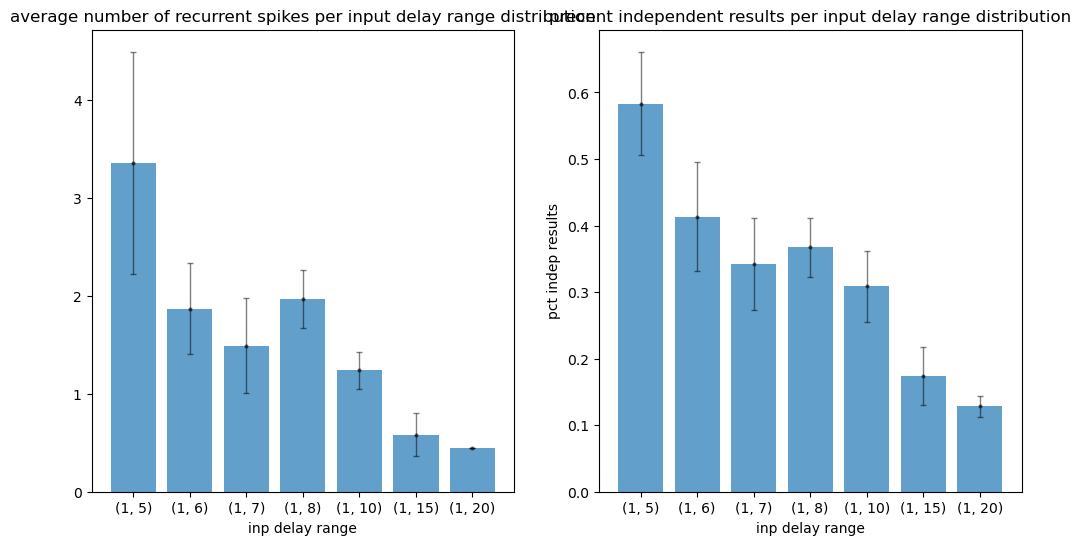

In [412]:
fig,ax = plt.subplot_mosaic('AB',figsize=(12,6))

a = np.arange(0,len(mean_spikes))

yerr=std_spikes
ax['A'].bar(a,mean_spikes,alpha=0.7)
ax['A'].errorbar(a,mean_spikes, yerr, fmt='.', color='Black', elinewidth=1,capthick=1,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax['A'].set_xticks(a,labels=xlabels)
ax['A'].set_xlabel('inp delay range')
ax['B'].set_ylabel('ave num rec spikes')
ax['A'].set_title('average number of recurrent spikes per input delay range distribution')

yerr=std_pct_indep
b = np.arange(0,len(mean_pct_indep))
ax['B'].bar(b,mean_pct_indep,alpha=0.7)
ax['B'].errorbar(a,mean_pct_indep, yerr, fmt='.', color='Black', elinewidth=1,capthick=1,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax['B'].set_xticks(b,labels=xlabels)
ax['B'].set_xlabel('inp delay range')
ax['B'].set_ylabel('pct indep results')
ax['B'].set_title('precent independent results per input delay range distribution')

plt.show()

In [183]:
events_dict.keys()

dict_keys(['inp_num', 'rec_num', 'inh_num', 'inh_duration', 'inp_delay_range', 'rec_delay_range', 'V_th'])

In [195]:
events_dict['inp_num'][2][0].shape, nrn_labels.shape

((1, 16, 100, 8), (8,))

In [210]:
nrn_labels

array([0, 0, 0, 1, 1, 1, 1, 2, 2])

In [211]:
colors = np.array(['#1f77b4', '#d62728', '#17becf'])
colors[nrn_labels]

array(['#1f77b4', '#1f77b4', '#1f77b4', '#d62728', '#d62728', '#d62728',
       '#d62728', '#17becf', '#17becf'], dtype='<U7')

In [213]:
np.where(current_events[i,...])[1]

array([1, 2, 0, 4, 6, 3, 4, 5, 7, 8, 7], dtype=int64)

In [269]:
list(events_dict[key].keys())

[0, 1, 2, 3, 4, 8, 12]

[0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
(16, 100, 18)


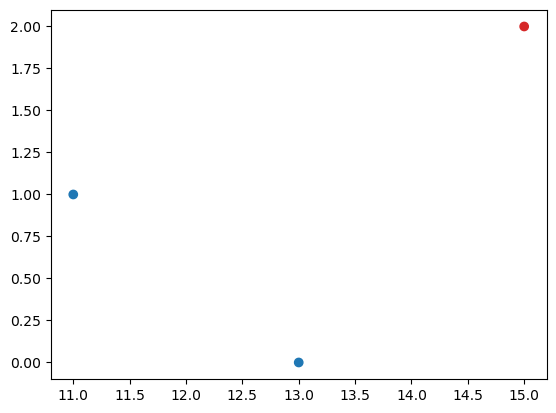

In [274]:
key = 'inh_num'
values = list(events_dict[key].keys())
val = values[-1]
current_events = events_dict[key][val][0][0,...]
nrn_labels = events_dict[key][val][1]
print(nrn_labels)
colors = np.array(['#1f77b4', '#d62728', '#17becf'])
colors = colors[nrn_labels]
print(current_events.shape)
plt.figure()
i=7
plt.scatter(np.where(current_events[i,...])[0],np.where(current_events[i,...])[1],c=colors[np.where(current_events[i,...])[1]])
plt.show()

In [181]:
current_events[i,...]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 